<a href="https://colab.research.google.com/github/hsuanchia/PTT-Gossiping-Chatbot/blob/main/gossip_chatbot_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sun Jun 20 08:10:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json,pickle
import numpy as np
import tensorflow as tf
from keras.layers import Input,Dropout,Embedding,LSTM,Dense,TimeDistributed
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from tqdm import tqdm

# Import Data

In [ ]:
q_path = '/content/drive/MyDrive/NLP/2021May_GossipingQA_question.json'
a_path = '/content/drive/MyDrive/NLP/2021May_GossipingQA_answer.json'
file_q = open(q_path,'r',encoding='utf8')
q_data = json.load(file_q)
file_a = open(a_path,'r',encoding='utf8')
a_data = json.load(file_a)

In [ ]:
q_data = np.array(q_data)
a_data = np.array(a_data)
q_data, a_data = shuffle(q_data,a_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
Q_word_to_index = pickle.load(open(f'/content/drive/MyDrive/NLP/Q_word-index.pkl', 'rb'))
Q_index_to_word = pickle.load(open(f'/content/drive/MyDrive/NLP/Q_index-word.pkl', 'rb'))
A_word_to_index = pickle.load(open(f'/content/drive/MyDrive/NLP/A_word-index.pkl', 'rb'))
A_index_to_word = pickle.load(open(f'/content/drive/MyDrive/NLP/A_index-word.pkl', 'rb'))

# Parameter Initialization

In [ ]:
start = '<sos>'
end = '<end>' 
unk = '<unk>'
pad = '<pad>'

In [ ]:
Q_word_to_index[start] = 31652
Q_word_to_index[end] = 31653
Q_word_to_index[unk] = 31654
Q_index_to_word[31652] = start
Q_index_to_word[31653] = end
Q_index_to_word[31654] = unk

A_word_to_index[start] = 36397
A_word_to_index[end] = 36398
A_word_to_index[unk] = 36399
A_index_to_word[36397] = start
A_index_to_word[36398] = end
A_index_to_word[36399] = unk

Q_max_length = 30 #q_data max = 30, a_data max = 59
A_max_length = 60
Q_vocsize = len(Q_word_to_index)
A_vocsize = len(A_word_to_index)
embedding_dim = 300
unit = 512

# Data Preprocessing

In [ ]:
def fit_sentence(sentence,word2index,max_length): 
  ans = []
  for i in sentence:
    if i in word2index.keys():
      ans.append(word2index[i])
    else:
      ans.append(word2index[unk]) #如果word找不到index,則通通設為unk
  seq = pad_sequences([ans],maxlen=max_length,padding='post')
  return seq

In [ ]:
def Q_data_generator(data,word2index,max_length):
  out = []
  for i in tqdm(data):
    seq = [start]
    seq.extend(i[0])
    seq.append(end)
    out_seq = fit_sentence(seq,word2index,max_length);
    out.append(out_seq)
  return np.array(out)

In [ ]:
def A_data_generator(data,word2index,max_length):
  out1, out2 = [], []
  for i in tqdm(data):
    seq = [start]
    seq.extend(i[0])
    seq.append(end)
    seq1, seq2 = seq[:-1], seq[1:]
    o1 = fit_sentence(seq1,word2index,max_length)
    o2 = fit_sentence(seq2,word2index,max_length)
    out1.append(o1)
    out2.append(o2)
  return np.array(out1), np.array(out2)

In [ ]:
# 處理question
Q = Q_data_generator(q_data,Q_word_to_index,Q_max_length)

100%|██████████| 48560/48560 [00:01<00:00, 30963.96it/s]


In [ ]:
# 處理answer
# ex: 原本的答案假設是[1,2,3,4,5,6]
# A1 = [1,2,3,4,5]; A2 = [2,3,4,5,6]
A1, A2 = A_data_generator(a_data,A_word_to_index,A_max_length) 

100%|██████████| 48560/48560 [00:03<00:00, 14933.90it/s]


In [ ]:
# 將資料降維: (None,1,max_length) -> (None,max_length)
Q = np.squeeze(Q)
A1 = np.squeeze(A1)
A2 = np.squeeze(A2)

In [ ]:
# 分割資料
q_train,q_val = Q[:40000],Q[40000:]
a1_train,a1_val = A1[:40000],A1[40000:]
a2_train,a2_val = A2[:40000],A2[40000:]
print('Train: ', len(q_train))
print('Validation: ', len(q_val))

Train:  40000
Validation:  8560


# Model

Model: "Gossip_ChatBot"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
A_input (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
Q_emb (Embedding)               (None, 30, 300)      9496500     Q_input[0][0]                    
__________________________________________________________________________________________________
A_emb (Embedding)               (None, 60, 300)      10920000    A_input[0][0]                    
_____________________________________________________________________________________

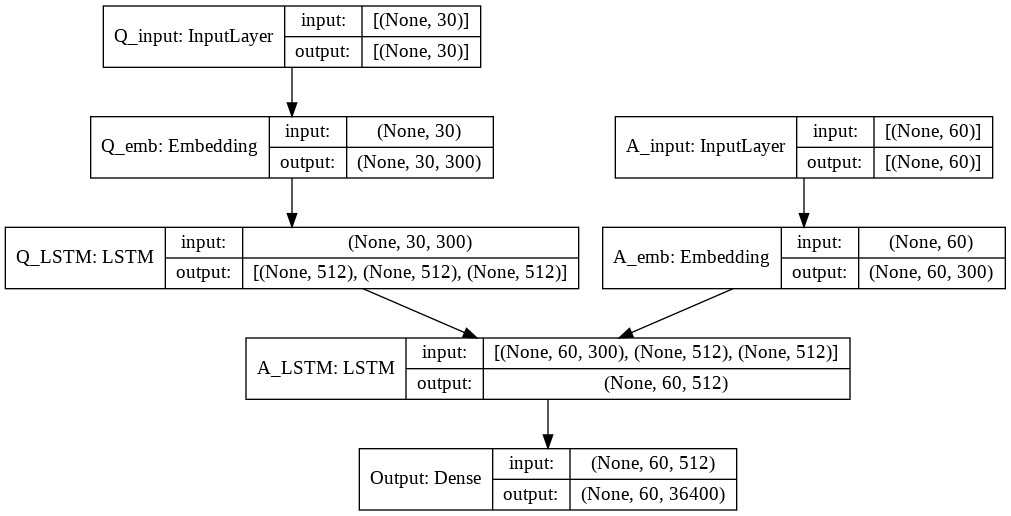

In [ ]:
Q_in = Input((Q_max_length,),name='Q_input')
Q_emb = Embedding(Q_vocsize+1,embedding_dim,mask_zero=True,name='Q_emb')(Q_in)
Q_out, Q_h, Q_c = LSTM(unit,return_state=True,recurrent_dropout=0.2,name='Q_LSTM')(Q_emb)
Q_state = [Q_h,Q_c]
A_in = Input((A_max_length,),name='A_input')
A_emb = Embedding(A_vocsize+1,embedding_dim,mask_zero=True,name='A_emb')(A_in)
A_out = LSTM(unit,return_sequences=True,recurrent_dropout=0.2,name='A_LSTM')(A_emb,initial_state=Q_state)
output = Dense(A_vocsize+1,activation='softmax',name='Output')(A_out)

model = Model(inputs=[Q_in,A_in],outputs=output,name='Gossip_ChatBot')
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['sparse_categorical_accuracy'])

tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
my_callbacks = [EarlyStopping(patience=5,monitor='val_loss')] 
model.fit((q_train,a1_train),a2_train,epochs=100,validation_data=((q_val,a1_val),a2_val),callbacks=my_callbacks)

Epoch 1/100
1250/1250 [==============================] - 398s 315ms/step - loss: 1.6839 - sparse_categorical_accuracy: 0.1904 - val_loss: 1.4362 - val_sparse_categorical_accuracy: 0.2475
Epoch 2/100
1250/1250 [==============================] - 385s 308ms/step - loss: 1.3828 - sparse_categorical_accuracy: 0.2500 - val_loss: 1.4014 - val_sparse_categorical_accuracy: 0.2609
Epoch 3/100
1250/1250 [==============================] - 382s 306ms/step - loss: 1.2999 - sparse_categorical_accuracy: 0.2698 - val_loss: 1.3916 - val_sparse_categorical_accuracy: 0.2667
Epoch 4/100
1250/1250 [==============================] - 379s 303ms/step - loss: 1.2307 - sparse_categorical_accuracy: 0.2866 - val_loss: 1.3961 - val_sparse_categorical_accuracy: 0.2714
Epoch 5/100
1250/1250 [==============================] - 373s 298ms/step - loss: 1.1663 - sparse_categorical_accuracy: 0.2990 - val_loss: 1.4076 - val_sparse_categorical_accuracy: 0.2704
Epoch 6/100
1250/1250 [==============================] - 374s 300

In [ ]:
model.save('/content/drive/MyDrive/NLP/Gossip_chatbot_9.h5')

In [ ]:
model = model.load

In [ ]:
def fit_sentence(seq,word2index,max_length):
    out_seq = token.texts_to_sequences(seq)
    tmp = [[word_index[start]]]
    tmp.extend(out_seq)
    tmp.append([word_index[end]])
    out_seq = tmp
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')
    out_seq = np.squeeze(out_seq)
    return out_seq

In [ ]:
temperature = 0.8
while True:
  question = input('公威阿: ')
  if question == '滾': # 輸入 '滾' 即可結束Chat Bot
    print('...88')
    break
  ans_seq = ''
  cur_token = start
  word_count = 1
  target_seq = np.zeros((1,A_max_length),dtype='int64')
  target_seq[0,0] = word_index[start]
  q = fit_sentence(question,word_index,Q_max_length)
  q = np.squeeze(q)
  q = tf.expand_dims(q,0)
  while word_count < A_max_length:
    decoder_output = model.predict([q,target_seq])
    decoder_output /= temperature
    ind = np.argmax(decoder_output[0,word_count])
    cur_token = index_word[ind]
    if cur_token == end:
      break
    ans_seq += cur_token
    target_seq[0,word_count] = ind
    word_count += 1
  print(ans_seq)